In [1]:
#kernel = .venv

import time
from time import time
t0=time()

import pandas as pd 
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn import tree
#from sklearn.tree import DecisionTreeRegressor
#from sklearn.tree import export_text

import matplotlib.pyplot as plt

t1=time()
print('time to load libraries=',round(t1-t0,1),'s')

time to load libraries= 1.8 s


In [2]:
t1=time()

#create synthetic data
N_train=7500000
N_test =2500000

N_train=75000
N_test =25000

#number of attributes
nx_=7
#nx_=1 #25 minutes for the entire notebook

x_train=np.random.rand(N_train,nx_) #train & test data are separately generated
y_train=np.zeros(N_train)
x_test=np.random.rand(N_test,nx_)
y_test=np.zeros(N_test)


#with vectorization
def myfunc7(x):
    y=np.zeros(len(x))
    for i in range(7+1):
        y=y+np.power(x[:,0]*4,i)
    #a sort of step function
    y=np.where(y>=1600,1600,np.where(y>=1200,1200,np.where(y>=800,800,np.where(y>=400,400,y))))/1600
    #create multiplication & division of other columns
    y=y+x[:,1]+np.power(x[:,2],2)+x[:,3]*x[:,4]+x[:,5]/(1+x[:,6])
    return y

#with vectorization
def myfunc1(x):
    y=np.zeros(len(x))
    for i in range(7+1):
        y=y+np.power(x[:,0]*4,i)
    y=np.where(y>=1600,1600,np.where(y>=1200,1200,np.where(y>=800,800,np.where(y>=400,400,y))))/1600
    return y



#vfunc = np.vectorize(myfunc) #it actually hurts the performance

if nx_==7:
    y_train=myfunc7(x_train)
    y_test=myfunc7(x_test)
elif nx_==1:
    y_train=myfunc1(x_train)
    y_test=myfunc1(x_test)

ymax=max(y_train)

y_train=y_train/ymax #a very simple normalization
y_test=y_test/ymax

t2=time(); print('time to generate synthetic data=',round(t2-t1,1),'s'); t1=t2 

time to generate synthetic data= 0.1 s


In [3]:
t1=time()

max_depth_=10

frac_leaf_=1/1000
min_leaf_=40


regr_1 = tree.DecisionTreeRegressor(splitter='best',
                                    min_samples_leaf=int(max(len(x_train)*frac_leaf_,min_leaf_)),max_depth=max_depth_)
regr_1.fit(x_train, y_train)

y_test_hat = regr_1.predict(x_test)

mse = mean_squared_error(y_test,y_test_hat)
print('#MSE * 1e4 = ', round(mse*1e4,3))

t2=time(); print('\r\ntime for prediction (inference)=',round(t2-t1,1),'s'); t1=t2

#MSE * 1e4 =  20.492

time for prediction (inference)= 0.7 s


In [4]:
tree.DecisionTreeRegressor.get_params(regr_1,deep=False)

{'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': 10,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 75,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': None,
 'splitter': 'best'}

In [5]:
#export decision tree to a string
r = tree.export_text(regr_1, feature_names=['x['+str(i)+']' for i in range(nx_)]
                     ,show_weights=True,decimals=5,max_depth=max_depth_,spacing=3)

In [6]:
#convert r to python function

r=r.replace('|   ', '\t')
r=r.replace('|--- value:', 'v_=')
r=r.replace('\n', ':\n')
r=r.replace(']:', ']')
r=r.replace('|--- ', 'if ')
r='def f_tree(x):\n'+r
r=r.replace('\n', '\n\t')
r=r+'\n\t'
r=r+'return v_[0]\n'
r=r+'def ff_(x):\n\treturn 0'
#print(r)

f= open("function_tree.py","w+")
f.write(r)
f.close() 

#del function_tree.f_tree

In [7]:
#from function_tree import ff_
import function_tree


In [8]:
function_tree.f_tree(x_test[0])

0.28889

In [9]:
y_test_hat_00=np.zeros(len(y_test_hat))
for i in range(len(y_test_hat)):
    y_test_hat_00[i]=function_tree.f_tree(x_test[i])

In [10]:
print(mean_squared_error(y_test,y_test_hat_00))
print(mean_squared_error(y_test,y_test_hat))

0.0020491894163578907
0.0020491895405800186


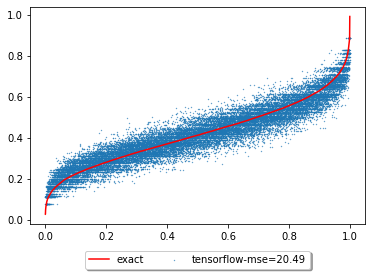

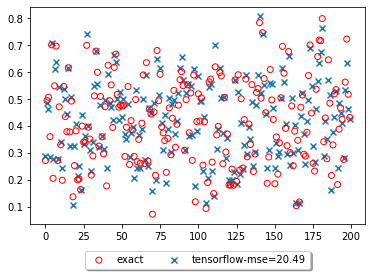

In [11]:
#plotting the results
ind_test=np.argsort(y_test)

plt.plot(np.arange(len(y_test))/len(y_test),y_test[ind_test], label='exact',zorder=2,color='red')

plt.scatter(np.arange(len(y_test))/len(y_test),y_test_hat[ind_test], 
            label='tensorflow-mse='+str(round(mse*1e4,2)),marker='o',s=0.1,zorder=1)

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),fancybox=True, shadow=True, ncol=5)
plt.show()


plt.scatter(np.arange(200),y_test[0:200], label='exact',zorder=2,marker='o', facecolors='none', edgecolor='red')
plt.scatter(np.arange(200),y_test_hat[0:200], 
            label='tensorflow-mse='+str(round(mse*1e4,2)),marker='x',zorder=1)

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),fancybox=True, shadow=True, ncol=5)
plt.show()


In [12]:
#create column names
col_names__=['x['+str(j)+']' for j in range(len(x_test[0])+1)]
col_names__[len(x_test[0])]='y'
col_names__


['x[0]', 'x[1]', 'x[2]', 'x[3]', 'x[4]', 'x[5]', 'x[6]', 'y']

In [13]:
#write original data to csv file using pandas because it's faster than python's write?
pd.DataFrame(np.column_stack((x_test,y_test)),columns=col_names__).to_csv('data___.csv', index=False)